In [1]:
#Members: 
#Sharnpreet Singh - Id#: 219445227  
#James Ochieng - Id#: 219285977
#Palvinder Singh- Id#: 219445344

import json
import csv
import pandas as pd
import numpy as np
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn import metrics
from tensorflow.keras.datasets import mnist
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from collections.abc import Sequence
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

pd.set_option("display.max_columns", None)
#READ THE CSV FILE INTO DATAFRAME
df= pd.read_csv('network_intrusion_data.csv',na_values=['NA',' ','?'])

In [2]:
#ADD COLUMNS TO THE DATAFRAME
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',   
              'num_failed_logins', 'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
              'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count', 
              'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
              'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate', 
              'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
              'dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome'] 

In [3]:
#DROP DUPLICATES
df_new=df.drop_duplicates()

In [4]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def store_results(activation,optimizer,kernel_num,kernel_size,y_true,pred):
    accuracy = metrics.accuracy_score(y_true, pred)
    #print("Accuracy score: {}".format(score))
    precision = metrics.precision_score(y_true, pred, average= "weighted")
    #print("Precision score: {}".format(score))
    recall = metrics.recall_score(y_true, pred, average= "weighted")
    #print("Recall score: {}".format(score))
    f1 = metrics.f1_score(y_true, pred, average= "weighted")
    #print("F1 score: {}".format(score))
    df_model_data.loc[len(df_model_data.index)] = [activation,optimizer, kernel_num, kernel_size,accuracy,precision,recall,f1]

In [5]:
df_new=df_new.dropna()
df_model_data=pd.DataFrame(columns =['ACTIVATION','OPTIMIZER','KERNEL NUMBER','KERNEL SIZE','ACCURACY','PRECISION','RECALL','F1 SCORE'])

In [6]:
#Encode Good Connections as "0" AND Attacks as "1"
encode_text_index(df_new,'protocol_type')
encode_text_index(df_new,'service')
encode_text_index(df_new,'flag')

array(['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3',
       'SF', 'SH'], dtype=object)

In [7]:
#CREATE A DICTIONARY FOR VALUES
attacks_to_num={'normal.':0,
               'back.':1,
               'buffer_overflow.':1,
               'ftp_write.':1,
               'guess_passwd.':1,
               'imap.':1,
               'ipsweep.':1,
               'land.':1,
               'loadmodule.':1,
               'multihop.':1,
               'neptune.':1,
               'nmap.':1,
               'perl.':1,
               'phf.':1,
               'pod.':1,
               'portsweep.':1,
               'rootkit.':1,
               'satan.':1,
               'smurf.':1,
               'spy.':1,
               'teardrop.':1,
               'warezclient.':1,
               'warezmaster.':1};
df_new['outcome']=df['outcome'].map(attacks_to_num)

In [8]:
encode_numeric_zscore(df_new, 'duration')
encode_numeric_zscore(df_new, 'src_bytes')
encode_numeric_zscore(df_new, 'dst_bytes')
encode_numeric_zscore(df_new, 'wrong_fragment')
encode_numeric_zscore(df_new, 'urgent')

encode_numeric_zscore(df_new, 'hot')
encode_numeric_zscore(df_new, 'num_failed_logins')
encode_numeric_zscore(df_new, 'num_compromised')
encode_numeric_zscore(df_new, 'root_shell')
encode_numeric_zscore(df_new, 'su_attempted')

encode_numeric_zscore(df_new, 'num_root')
encode_numeric_zscore(df_new, 'num_file_creations')
encode_numeric_zscore(df_new, 'num_shells')
encode_numeric_zscore(df_new, 'num_access_files')
encode_numeric_zscore(df_new, 'num_outbound_cmds')
encode_numeric_zscore(df_new, 'count')
encode_numeric_zscore(df_new, 'serror_rate')
encode_numeric_zscore(df_new, 'rerror_rate')
encode_numeric_zscore(df_new, 'same_srv_rate')
encode_numeric_zscore(df_new, 'diff_srv_rate')
encode_numeric_zscore(df_new, 'srv_count')
encode_numeric_zscore(df_new, 'srv_serror_rate')
encode_numeric_zscore(df_new, 'srv_rerror_rate')
encode_numeric_zscore(df_new, 'srv_diff_host_rate')

encode_numeric_zscore(df_new, 'dst_host_count')
encode_numeric_zscore(df_new, 'dst_host_srv_count')
encode_numeric_zscore(df_new, 'dst_host_same_srv_rate')
encode_numeric_zscore(df_new, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df_new, 'srv_count')
encode_numeric_zscore(df_new, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df_new, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df_new, 'dst_host_serror_rate')
encode_numeric_zscore(df_new, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df_new, 'dst_host_rerror_rate')
encode_numeric_zscore(df_new, 'dst_host_srv_rerror_rate')


df_new=df_new.drop('num_outbound_cmds',axis=1)
#df_new

In [9]:
#ONE_HOT ENCODE
encode_text_dummy(df_new,'protocol_type')
encode_text_dummy(df_new,'service')
encode_text_dummy(df_new,'flag')

In [10]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
#SPLIT DATA
encode_text_dummy(df_new,'outcome')
y=df_new[['outcome-0','outcome-1']]
df_new=df_new.drop('outcome-0',axis=1)
df_new=df_new.drop('outcome-1',axis=1)
x=df_new;

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test=x_test.to_numpy()
y_test=y_test.to_numpy()


In [39]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION RELU AND OPTIMIZER ADAM
from tensorflow.keras.callbacks import ModelCheckpoint
model=Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
np.set_printoptions(threshold=np.inf)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('RELU','ADAM',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 2s - loss: 0.0237 - accuracy: 0.9940 - val_loss: 0.0639 - val_accuracy: 0.9976
Epoch 2/1000
3640/3640 - 2s - loss: 0.0249 - accuracy: 0.9974 - val_loss: 0.0777 - val_accuracy: 0.9979
Epoch 3/1000
3640/3640 - 2s - loss: 0.0056 - accuracy: 0.9977 - val_loss: 0.0943 - val_accuracy: 0.9980
Epoch 4/1000
3640/3640 - 2s - loss: 0.0038 - accuracy: 0.9980 - val_loss: 0.1724 - val_accuracy: 0.9985
Epoch 5/1000
3640/3640 - 2s - loss: 0.0026 - accuracy: 0.9982 - val_loss: 0.1784 - val_accuracy: 0.9984
Epoch 6/1000
3640/3640 - 2s - loss: 0.0019 - accuracy: 0.9984 - val_loss: 0.1426 - val_accuracy: 0.9986
Epoch 00006: early stopping


[[17569    20]
 [   22 11506]]
Ploting confusion matrix for Activation: RELU & Optimizer: ADAM


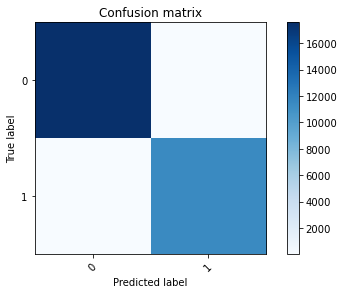

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [40]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: RELU & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [41]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION SIGMOID AND OPTIMIZER ADAM 
model=Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(40,activation='sigmoid'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('SIGMOID','ADAM',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 2s - loss: 0.0136 - accuracy: 0.9848 - val_loss: 0.0057 - val_accuracy: 0.9940
Epoch 2/1000
3640/3640 - 2s - loss: 0.0052 - accuracy: 0.9956 - val_loss: 0.0038 - val_accuracy: 0.9964
Epoch 3/1000
3640/3640 - 2s - loss: 0.0038 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 0.9970
Epoch 4/1000
3640/3640 - 2s - loss: 0.0031 - accuracy: 0.9972 - val_loss: 0.0028 - val_accuracy: 0.9976
Epoch 5/1000
3640/3640 - 2s - loss: 0.0027 - accuracy: 0.9975 - val_loss: 0.0025 - val_accuracy: 0.9975
Epoch 6/1000
3640/3640 - 2s - loss: 0.0025 - accuracy: 0.9976 - val_loss: 0.0021 - val_accuracy: 0.9978
Epoch 7/1000
3640/3640 - 2s - loss: 0.0023 - accuracy: 0.9979 - val_loss: 0.0024 - val_accuracy: 0.9979
Epoch 8/1000
3640/3640 - 2s - loss: 0.0021 - accuracy: 0.9981 - val_loss: 0.0021 - val_accuracy: 0.9982
Epoch 9/1000
3640/3640 - 2s - loss: 0.0020 - accuracy: 0.9982 - val_loss: 0.0019 - val_accuracy: 0.9983
Epoch 00009: early stopping


[[17564    25]
 [   24 11504]]
Ploting confusion matrix for Activation: SIGMOID & Optimizer: ADAM


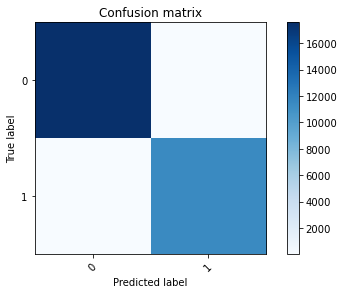

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: SIGMOID & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [43]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION TANH AND OPTIMIZER ADAM 
model=Sequential()
model.add(Dense(30, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(20,activation='tanh'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('TANH','ADAM',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 2s - loss: 0.0098 - accuracy: 0.9922 - val_loss: 0.0032 - val_accuracy: 0.9971
Epoch 2/1000
3640/3640 - 2s - loss: 0.0030 - accuracy: 0.9972 - val_loss: 0.0024 - val_accuracy: 0.9976
Epoch 3/1000
3640/3640 - 2s - loss: 0.0023 - accuracy: 0.9977 - val_loss: 0.0018 - val_accuracy: 0.9980
Epoch 4/1000
3640/3640 - 2s - loss: 0.0020 - accuracy: 0.9980 - val_loss: 0.0018 - val_accuracy: 0.9982
Epoch 5/1000
3640/3640 - 1s - loss: 0.0018 - accuracy: 0.9982 - val_loss: 0.0017 - val_accuracy: 0.9981
Epoch 6/1000
3640/3640 - 2s - loss: 0.0016 - accuracy: 0.9983 - val_loss: 0.0014 - val_accuracy: 0.9984
Epoch 7/1000
3640/3640 - 1s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.0015 - val_accuracy: 0.9984
Epoch 8/1000
3640/3640 - 2s - loss: 0.0014 - accuracy: 0.9986 - val_loss: 0.0015 - val_accuracy: 0.9984
Epoch 00008: early stopping


[[17569    20]
 [   26 11502]]
Ploting confusion matrix for Activation: TANH & Optimizer: ADAM


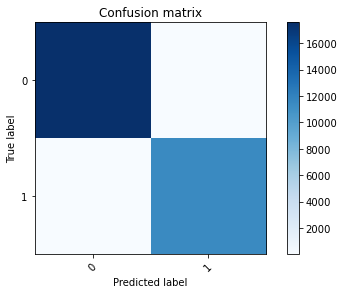

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [44]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: TANH & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [45]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION RELU AND OPTIMIZER SGD 
model=Sequential()
model.add(Dense(40, input_dim=x.shape[1], activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('RELU','SGD',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 1s - loss: 0.0349 - accuracy: 0.9769 - val_loss: 0.0163 - val_accuracy: 0.9837
Epoch 2/1000
3640/3640 - 1s - loss: 0.0146 - accuracy: 0.9839 - val_loss: 0.0119 - val_accuracy: 0.9859
Epoch 3/1000
3640/3640 - 1s - loss: 0.0098 - accuracy: 0.9878 - val_loss: 0.0108 - val_accuracy: 0.9927
Epoch 4/1000
3640/3640 - 1s - loss: 0.0079 - accuracy: 0.9931 - val_loss: 0.0103 - val_accuracy: 0.9943
Epoch 5/1000
3640/3640 - 1s - loss: 0.0062 - accuracy: 0.9947 - val_loss: 0.0088 - val_accuracy: 0.9957
Epoch 6/1000
3640/3640 - 1s - loss: 0.0053 - accuracy: 0.9954 - val_loss: 0.0090 - val_accuracy: 0.9960
Epoch 7/1000
3640/3640 - 1s - loss: 0.0049 - accuracy: 0.9956 - val_loss: 0.0086 - val_accuracy: 0.9962
Epoch 8/1000
3640/3640 - 1s - loss: 0.0045 - accuracy: 0.9961 - val_loss: 0.0081 - val_accuracy: 0.9964
Epoch 9/1000
3640/3640 - 1s - loss: 0.0044 - accuracy: 0.9964 - val_loss: 0.0082 - val_accuracy: 0.9965
Epoch 10/1000
3640/3640 - 1s - loss: 0.0041 - accuracy: 0.9965 -

[[17542    47]
 [   62 11466]]
Ploting confusion matrix for Activation: RELU & Optimizer: SGD


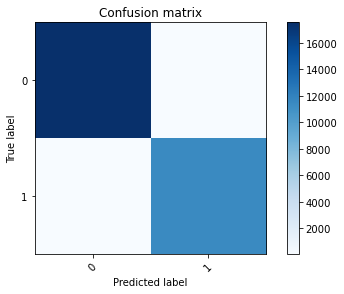

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      0.99      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [46]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: RELU & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [47]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION SIGMOID AND OPTIMIZER SGD 
model=Sequential()
model.add(Dense(40, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(20,activation='sigmoid'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('SIGMOID','SGD',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 1s - loss: 0.0635 - accuracy: 0.9358 - val_loss: 0.0288 - val_accuracy: 0.9771
Epoch 2/1000
3640/3640 - 1s - loss: 0.0265 - accuracy: 0.9767 - val_loss: 0.0248 - val_accuracy: 0.9770
Epoch 3/1000
3640/3640 - 1s - loss: 0.0236 - accuracy: 0.9769 - val_loss: 0.0225 - val_accuracy: 0.9775
Epoch 4/1000
3640/3640 - 1s - loss: 0.0218 - accuracy: 0.9778 - val_loss: 0.0210 - val_accuracy: 0.9780
Epoch 5/1000
3640/3640 - 1s - loss: 0.0203 - accuracy: 0.9785 - val_loss: 0.0195 - val_accuracy: 0.9792
Epoch 6/1000
3640/3640 - 1s - loss: 0.0190 - accuracy: 0.9791 - val_loss: 0.0183 - val_accuracy: 0.9791
Epoch 7/1000
3640/3640 - 1s - loss: 0.0179 - accuracy: 0.9798 - val_loss: 0.0172 - val_accuracy: 0.9801
Epoch 8/1000
3640/3640 - 1s - loss: 0.0168 - accuracy: 0.9814 - val_loss: 0.0162 - val_accuracy: 0.9823
Epoch 9/1000
3640/3640 - 1s - loss: 0.0158 - accuracy: 0.9823 - val_loss: 0.0152 - val_accuracy: 0.9835
Epoch 10/1000
3640/3640 - 1s - loss: 0.0149 - accuracy: 0.9829 -

[[17506    83]
 [  226 11302]]
Ploting confusion matrix for Activation: SIGMOID & Optimizer: SGD


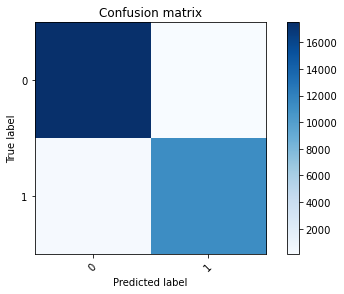

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17589
           1       0.99      0.98      0.99     11528

    accuracy                           0.99     29117
   macro avg       0.99      0.99      0.99     29117
weighted avg       0.99      0.99      0.99     29117



In [48]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: SIGMOID & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [49]:
#FULLY CONNECTED NEURAL MODEL WITH ACTIVATION TANH AND OPTIMIZER SGD 
model=Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(40,activation='tanh'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('TANH','SGD',' ' ,' ',y_true,pred)

Epoch 1/1000
3640/3640 - 1s - loss: 0.0199 - accuracy: 0.9793 - val_loss: 0.0123 - val_accuracy: 0.9843
Epoch 2/1000
3640/3640 - 1s - loss: 0.0107 - accuracy: 0.9860 - val_loss: 0.0094 - val_accuracy: 0.9897
Epoch 3/1000
3640/3640 - 1s - loss: 0.0086 - accuracy: 0.9915 - val_loss: 0.0077 - val_accuracy: 0.9929
Epoch 4/1000
3640/3640 - 1s - loss: 0.0072 - accuracy: 0.9937 - val_loss: 0.0067 - val_accuracy: 0.9942
Epoch 5/1000
3640/3640 - 1s - loss: 0.0063 - accuracy: 0.9946 - val_loss: 0.0058 - val_accuracy: 0.9950
Epoch 6/1000
3640/3640 - 1s - loss: 0.0056 - accuracy: 0.9953 - val_loss: 0.0052 - val_accuracy: 0.9953
Epoch 7/1000
3640/3640 - 1s - loss: 0.0051 - accuracy: 0.9959 - val_loss: 0.0048 - val_accuracy: 0.9958
Epoch 8/1000
3640/3640 - 1s - loss: 0.0047 - accuracy: 0.9961 - val_loss: 0.0045 - val_accuracy: 0.9964
Epoch 9/1000
3640/3640 - 1s - loss: 0.0045 - accuracy: 0.9963 - val_loss: 0.0043 - val_accuracy: 0.9964
Epoch 10/1000
3640/3640 - 1s - loss: 0.0043 - accuracy: 0.9965 -

[[17544    45]
 [   43 11485]]
Ploting confusion matrix for Activation: TANH & Optimizer: SGD


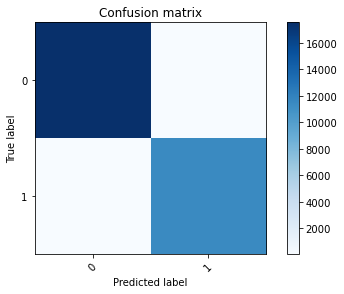

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [50]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: TANH & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION RELU AND OPTIMIZER ADAM
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('RELU','ADAM','32' ,'(3,3)',y_true,pred)

Epoch 1/1000


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: RELU & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION SIGMOID AND OPTIMIZER ADAM
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='valid'))
cnn.add(Activation('sigmoid'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='sigmoid'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('SIGMOID','ADAM','32' ,'(3,3)',y_true,pred)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: SIGMOID & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION TANH AND OPTIMIZER ADAM
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='valid'))
cnn.add(Activation('tanh'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='tanh'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('TANH','ADAM','32' ,'(3,3)',y_true,pred)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: TANH & Optimizer: ADAM')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION RELU AND OPTIMIZER SGD
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('RELU','SGD','32' ,'(3,3)',y_true,pred)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: RELU & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION SIGMOID AND OPTIMIZER SGD
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(1, 1), padding='valid'))
cnn.add(Activation('sigmoid'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='sigmoid'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('SIGMOID','SGD','32' ,'(3,3)',y_true,pred)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: SIGMOID & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
#CNN MODEl WITH ACTIVATION TANH AND OPTIMIZER SGD
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),strides=(2, 2), padding='valid'))
cnn.add(Activation('tanh'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dense(128, activation='tanh'))
cnn.add(Dropout(0.5))
cnn.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
cnn = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
store_results('TANH','SGD','32' ,'(3,3)',y_true,pred)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)
print('Ploting confusion matrix for Activation: TANH & Optimizer: SGD')
plt.figure()
label=np.array([0,1])
plot_confusion_matrix(cm,label)
plt.show()
print(classification_report(y_true, pred))

In [ ]:
df_model_data